# Standalone Tracer Advection

This notebook demonstrates the computation of 2-dimensional tracer advection implemented in (?pace?). Tracer advection is performed over a single model layer with predefined thickness of 10 Pa, a Gaussian tracer distribution that is centered on `tracer_center`), and a known wind field.

The mass continuity equation for a conserved scalar mass density $Q$ and horizontal vector velocity $\mathbf{v}$ is

$$
\frac{\partial Q}{\partial t} + \nabla \cdot (Q\mathbf{v}) = 0
$$

We can then use the Divergence theorem to integrate about a quadrilateral grid cell of area $\Delta A$, while simultaneously integrating in time from $t^n$ to $t^{n+1} = t^n + \Delta t$ to express the governing equation in finite (control)-volume form:

$$
\begin{aligned}
\begin{split}
Q^{n+1} & = Q^{n} - \frac{1}{A} \int^{t + \Delta t}_t \oint Q \, \mathbf{v} \cdot \vec{n} \, dl \, dt \\
& = Q^{n} + F[Q, \tilde{u}^*] + G[Q, \tilde{v}^*] \\
\end{split}
\end{aligned}
$$
where the $F$ and $G$ terms represent time-integrated flux divergences along grid-cell faces in x and y directions.

### Start a parallel cluster

In [1]:
# Number of tiles on the cube
ntiles = 6


nx = 100
ny = 100
nz = 1
""" (int): number of points per tile in each direction """
nhalo = 3
""" (int): number of halo points"""

timestep = 900.0
""" (int): advection time step in seconds """
nDays = 12
""" (int): number of days to advect for """

test_case = "b"
""" (string): 
    - a: fortran test_case1; 
    - b: similar to a, but less dispersive;  
    - c: south-north propagation """

figure_everyNhours = 6
""" (int): number of model hours between figures """
plot_output_after = False
""" (bool): plot output after advection is complete (slow) """

tracer_center = (0.0, 0.0)
""" (float, float): lon and lot of the center position of tracer """

# Number of MPI-ranks along x- and y-direction on each tile
# Note: Must be equal for the time being
layout = (1, 1)
assert layout[0] == layout[1]

# GT4Py backend to use for storages
backend = "numpy"

In [2]:
import ipyparallel as ipp

# spinup cluster of MPI-workers
num_ranks = ntiles * layout[0] * layout[1]
cluster = ipp.Cluster(engines="mpi", n=num_ranks).start_and_connect_sync()

# broadcast configuration to all workers
ar = cluster[:].push(
    {
        "ntiles": ntiles,
        "nx": nx,
        "ny": ny,
        "nz": nz,
        "nhalo": nhalo,
        "layout": layout,
        "backend": backend,
        "tracer_center": tracer_center,
        "timestep": timestep,
        "nDays": nDays,
        "test_case": test_case,
        "plot_output_after": plot_output_after,
        "figure_everyNhours": figure_everyNhours,
    }
)

# start executing cells on the workers in parallel from here on
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


### Input parameters

To set up an FV3 grid on 6 tiles, all you need to define `nx`, `ny` and `nhalo` (these apply to single-tile dimensions). The `timestep` and `nDays` parameters are used in trace advection, where 12 is the number of days it takes for the tracer to propagate around the globe with test case initial conditions.

There are currently two test cases defined:
- <b>a</b>: same configuration as test_case1 in fortran
- <b>b</b>: as in fortran test_case1, but with slightly weaker winds away from the equator, which leads to less dissipation after full rotation.
- <b>c</b>: same as 1, but for south-north propagation of tracer

### Configure based on input parameters

In [3]:
%%capture
import functions as func
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_rank = mpi_comm.Get_rank()

nSeconds = nDays * 86400
figure_everyNsteps = int(3600 / timestep * figure_everyNhours)
nSteps_advection = int(nSeconds / timestep + 1)

if figure_everyNsteps > nSteps_advection:
    figure_everyNsteps = nSteps_advection

write_coordinates = True

namelist_dict = func.store_namelist_variables(locals())

plot_dict_tracer = {
    "vmin": 0,
    "vmax": 1,
    "units": "",
    "title": "Tracer concentration",
    "cmap": "viridis",
}

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

### Prepare state for advection

This section steps through everything that is needed in order to run tracer advection. 

1. The domain is configured based on the input `nx`, `ny` and `nhalo` points.
    - The `configuration` dictionary stores all the constructs (I think?) that are needed to initialize stencils.
    - This is demonstrated in more detail in `domain_decomposition_grid_generation.ipynb`.
<br> <br>

2. The initial state fields are created based on chosen test case.
    - The `initialState` dictionary stores `delp`, `uC`, `vC` and `tracer` information required for advection.
    - This is demonstrated in more detail in `initial_condition_definition.ipynb`.
<br> <br>

3. The initial state fields are converted into inputs that tracer advection requires.
    - The `tracAdv_data` dictionary stores Courant numbers `crx` and `cry`, mass fluxes `mfxd` and `mfyd`, pressure thickness `delp` and tracer concentration dictionary `tracers`.

In [4]:
import copy as cp

dimensions = func.define_dimensions(namelist_dict)

domain_configuration = func.configure_domain(mpi_comm, dimensions)

initial_state = func.create_initial_state_advection(
    domain_configuration["metric_terms"], dimensions, tracer_center, test_case
)

if nz == 1:
    single_layer = True
else:
    single_layer = False

stencil_configuration = func.configure_stencil(domain_configuration, single_layer=single_layer)

tracer_advection_data, tracer_advection = func.prepare_everything_for_advection(
    stencil_configuration, initial_state, dimensions, timestep
)

tracer_advection_data_initial = cp.deepcopy(tracer_advection_data)

[stderr:2] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


[stderr:5] /home/ajdas/pace/pace-util/pace/util/grid/gnomonic.py:682: RuntimeWarning: invalid value encountered in true_divide
  np.sum(p * q, axis=-1)


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

## Advection loop

This section loops through tracer advection for the specificed number of steps (`nSteps_advection`) that are determined by the requested duration (`nDays`) and given time step (`timestep`). After every time step, the instantaneous tracer state is stored in `tracer_archive`.

You can choose to plot the instantaneous tracer during computation if `plot_outputDuring=True`, but this is very slow. Better plotting options are in the next section.

In [5]:
tracer_archive = [cp.deepcopy(tracer_advection_data_initial["tracers"]["tracer"])]

for step in range(nSteps_advection):
    if (mpi_rank == 0) and (step + 1) % (24 * 3600 / timestep) == 0:
        print("Step: %d" % (step + 1))

    tracer_advection_data = func.run_advection_step_with_reset(
        tracer_advection_data_initial, tracer_advection_data, tracer_advection, timestep
    )

    tracer_archive.append(cp.deepcopy(tracer_advection_data["tracers"]["tracer"]))

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[stdout:0] Step: 96
Step: 192
Step: 288
Step: 384
Step: 480
Step: 576
Step: 672
Step: 768
Step: 864
Step: 960
Step: 1056
Step: 1152


### Animation and Plotting

These sections run if `plot_jupyterAnimation` and `plot_outputAfter` are set to `True`.

- `plot_jupyterAnimation` creates an interactive interface where you can click through and play through the time progression of tracer advection.
- `plot_outputAfter` plots individual frames. 

In [6]:
lon, lat = func.get_lon_lat_edges(domain_configuration, dimensions, gather=True)

tracer_gather = []
for step in range(len(tracer_archive)):
    tracer_gather.append(domain_configuration["communicator"].gather(tracer_archive[step]))
      
if mpi_rank == 0:
    func.plot_tracer_animation(
        lon,
        lat,
        tracer_gather,
        plot_dict_tracer,
        figure_everyNsteps,
        timestep,
        frames="all",
    )

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

Plot a few frames for the Jupyter notebook

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

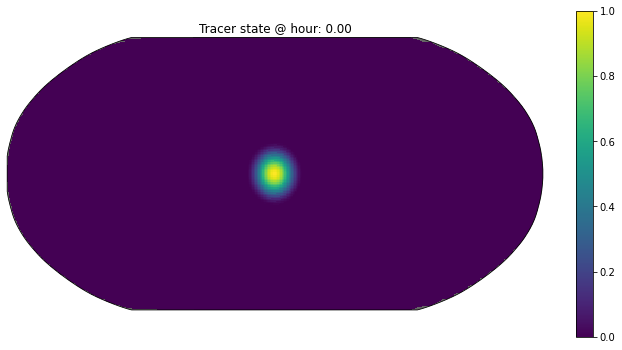

[output:0]

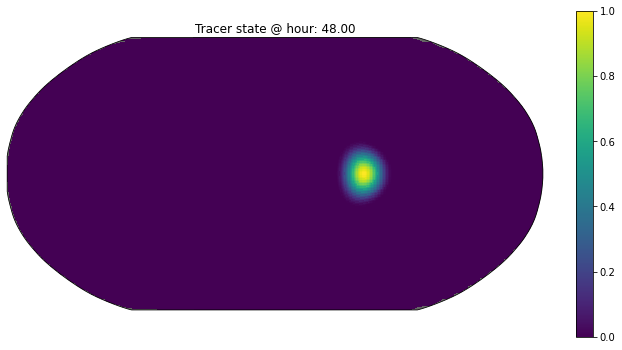

[output:0]

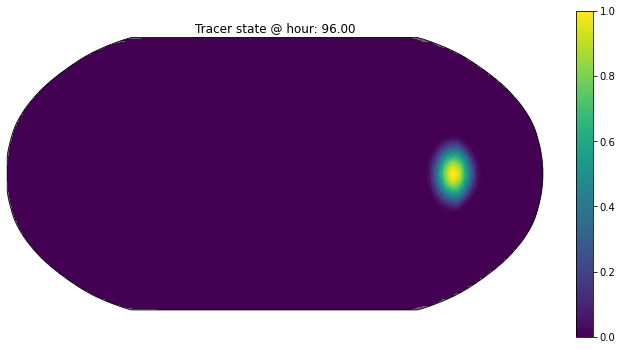

[output:0]

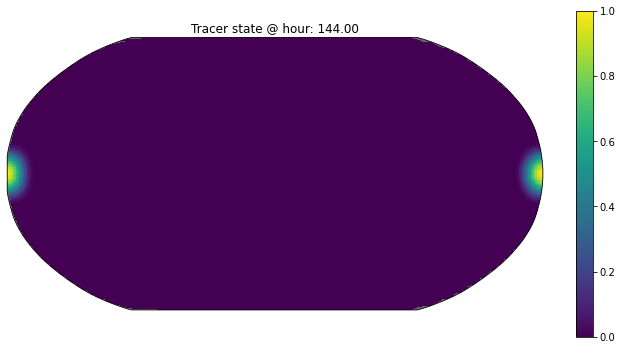

[output:0]

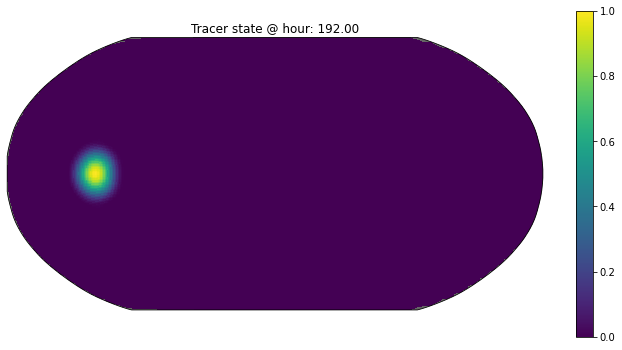

[output:0]

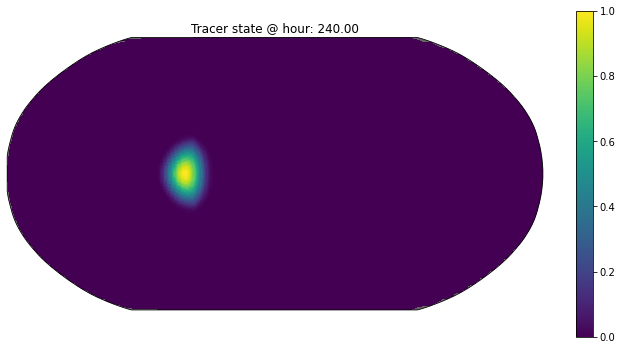

[output:0]

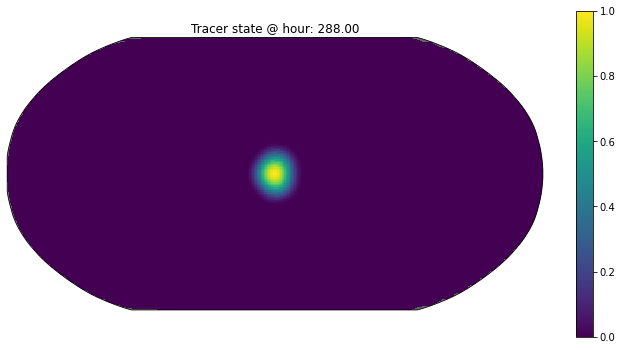

In [7]:
for step in range(0, nSteps_advection, 96*2): # every other day
    tracer_gather = domain_configuration["communicator"].gather(tracer_archive[step])
    fOut = "" # do not save
    plot_dict_tracer["title"] = "Tracer state @ hour: %.2f" % (
        (step * timestep) / 60 / 60
    )

    if mpi_rank == 0:
        func.plot_projection_field(
            lon, 
            lat,
            tracer_gather,
            plot_dict_tracer,
            fOut,
            show=True,
        )

If you want to make an animation (.gif), you need to first plot individual figures:

In [8]:
if plot_output_after:
    for step in range(0, nSteps_advection, figure_everyNsteps):
        tracer_gather = domain_configuration["communicator"].gather(tracer_archive[step])
        fOut = "tracerAdvection_%s_%06.2f.png" % (
            test_case,
            (step * timestep) / 60 / 60,
        )
        plot_dict_tracer["title"] = "Tracer state @ hour: %.2f" % (
            (step * timestep) / 60 / 60
        )

        if mpi_rank == 0:
            func.plot_projection_field(
                lon, 
                lat,
                tracer_gather,
                plot_dict_tracer,
                fOut,
                show=False,
            )